/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
step 1: elapsed 1.0602004528045654
step 2: elapsed 0.02055072784423828
step 3: elapsed 0.12722373008728027
step 4: elapsed 0.6093864440917969
-------------------------------------------
Handle transitivity:
	Intra:		 15
	Intra(choice):	 40
	Inter:		 415
	Inter(choice):	 621
-------------------------------------------
	Time =  850  ms
	result: 0

	Total cost: 1551.669291254836

# valid points:		 120
# invalid points:	 7
step 5: elapsed 0.8598952293395996
step 7: elapsed 0.030875444412231445

total elapsed: 2.7107434272766113


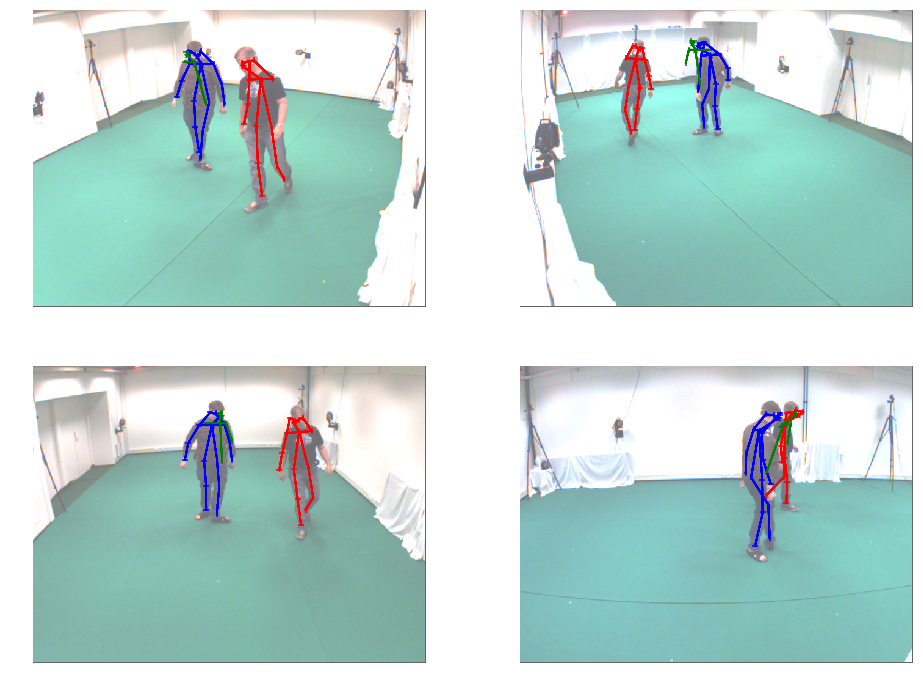

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import umpm

from mvpose.algorithm import settings

params = settings.get_settings(ms_radius=30)


root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

# **************************** #
FRAME = 51 * 30  # 51*30, 31*30
# **************************** #

X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, 
                                                        FRAME, 
                                                        dir=tmp)

# ==================================
from mvpose import pose
from mvpose.algorithm import graphcut

_start = time()
Debug, detections = pose.estimate_heuristic(
    Calib, heatmaps, pafs, 
    settings=params, debug=True, use_greedy=False)
_end = time()
print('\ntotal elapsed:', _end - _start)
# ==================================

from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
        
plt.show()

In [19]:
Humans[2]

[array([ 417.92774145, 1331.06128437, 1679.73431169]),
 array([ 431.16013292, 1184.70316686, 1564.69053663]),
 array([ 656.00007176, 1105.15109246, 1558.07900209]),
 None,
 None,
 array([ 347.36780275, 1293.86080491, 1564.55269042]),
 array([ 278.56945302, 1271.38576469, 1322.58562675]),
 None,
 None,
 None,
 None,
 array([430.80191261, 989.47192238, 965.70343011]),
 None,
 None,
 array([ 449.93096516, 1307.50781644, 1711.42944951]),
 array([ 401.14765041, 1333.91893376, 1718.4453308 ]),
 None,
 None]

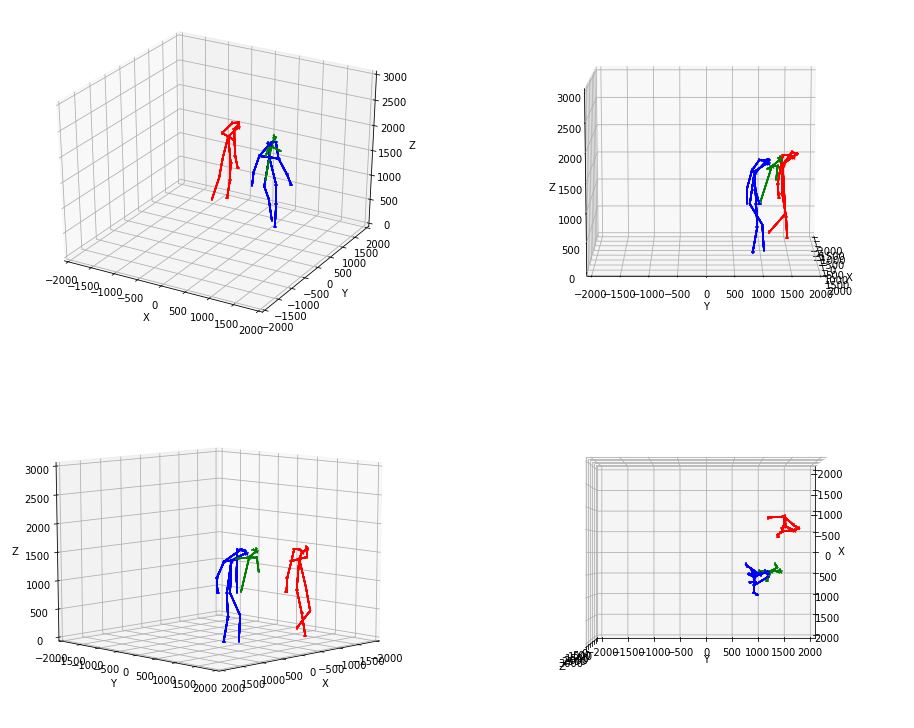

In [18]:
from mvpose.plot.limbs import draw_mscoco_human3d

def plot(ax, Humans):
    ax.set_xlim(-2000, 2000)
    ax.set_ylim(-2000, 2000)
    ax.set_zlim(0, 3000)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for pid, human in enumerate(Humans):
        draw_mscoco_human3d(ax, human, colors[pid])

fig = plt.figure(figsize=(16,13))
ax = fig.add_subplot(221, projection='3d')
plot(ax, Humans)
    
ax = fig.add_subplot(222, projection='3d')
ax.view_init(elev=10., azim=0)
plot(ax, Humans)
    
ax = fig.add_subplot(223, projection='3d')
ax.view_init(elev=10., azim=45)
plot(ax, Humans)

    
ax = fig.add_subplot(224, projection='3d')
ax.view_init(elev=90., azim=5)
plot(ax, Humans)
    
plt.show()

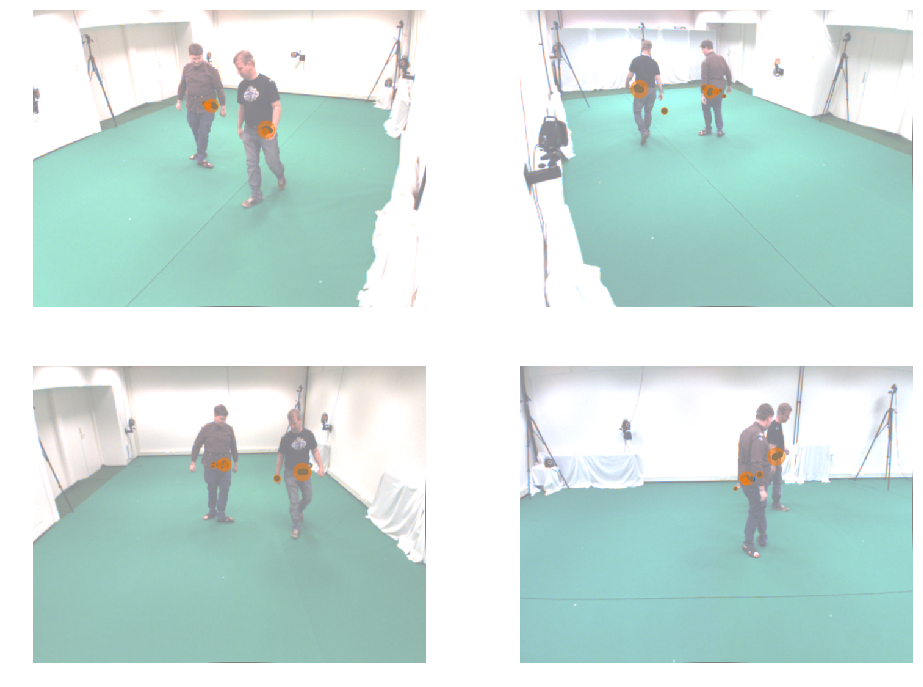

In [3]:
import mvpose.geometry.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


centers3d_with_w = Debug.meanshift.centers3d[JOINT]
centers3d = centers3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(2, 2, cid+1)
    mapx = cam.mapx
    mapy = cam.mapy
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    pts2d = cam.projectPoints_undist(pts3d)
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
    
    centers2d = cam.projectPoints_undist(centers3d)
    ax.scatter(centers2d[:,0], centers2d[:,1], s=centers3d_with_w[:,3] * 50, alpha=0.5)
    
plt.show()

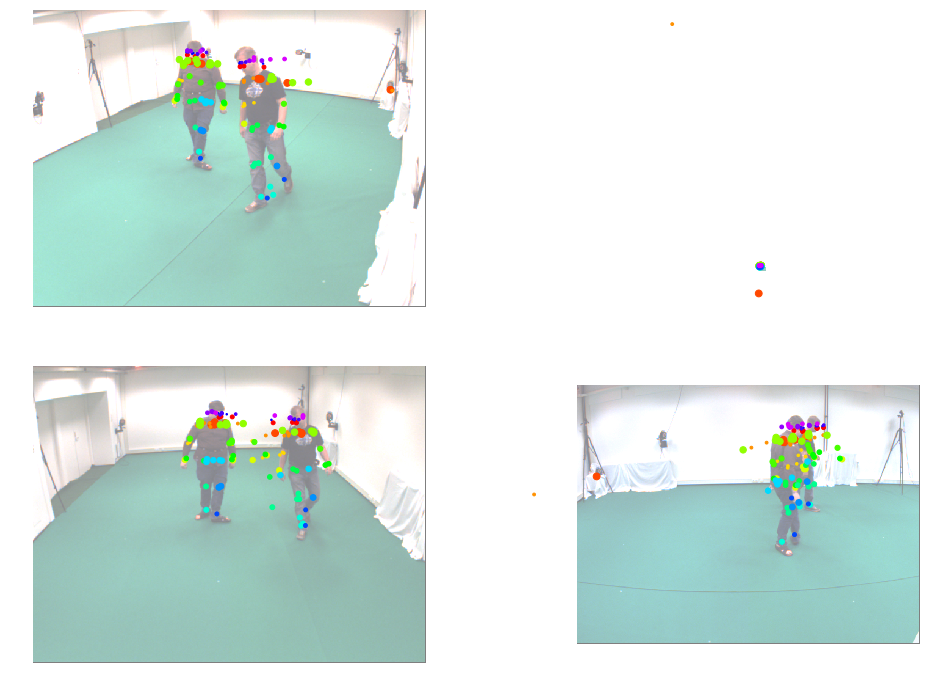

In [4]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*5)
    
plt.show()

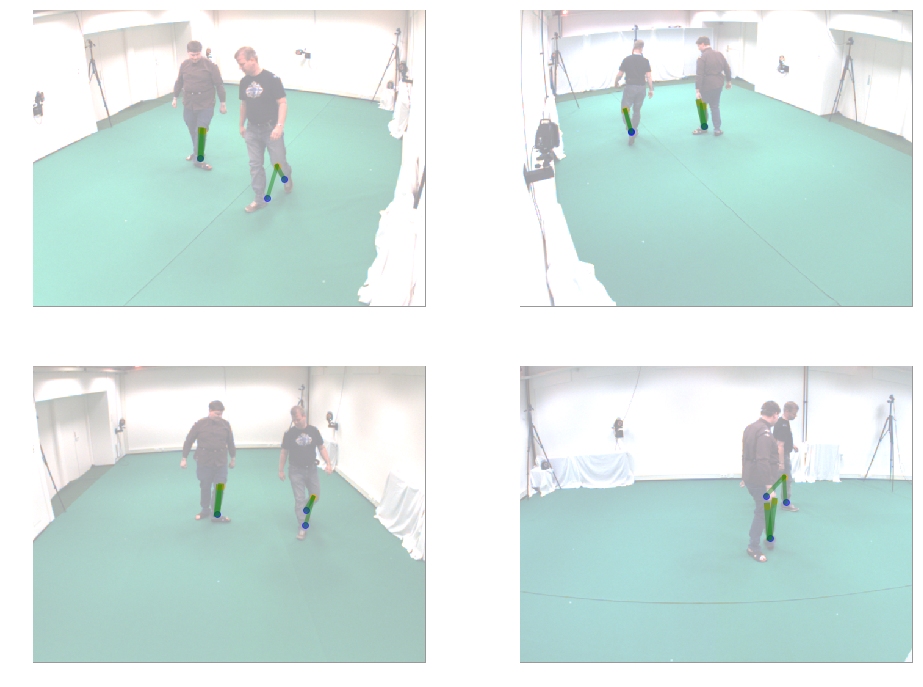

In [5]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

LIMB_ID = 11
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape

candA = Debug.meanshift.centers3d[a][:,0:3]
candB = Debug.meanshift.centers3d[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    for _a in np.squeeze(maskA):
        for _b in np.squeeze(maskB):
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            elif w > -99999:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()

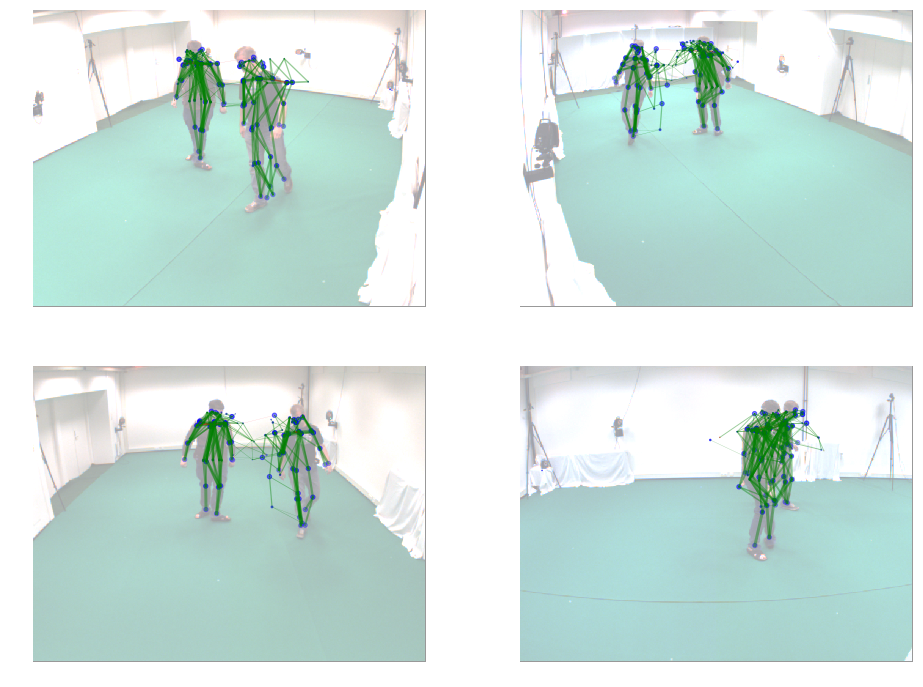

In [8]:
from mvpose.algorithm.graphcut import PBOOST_SMALL, get_unary

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)

        unaryA = get_unary(Debug.triangulation.peaks3d_weighted[a])[maskA]
        unaryA = PBOOST_SMALL(np.clip(unaryA, a_min=0.00000001, a_max=0.99999999))
        unaryB = get_unary(Debug.triangulation.peaks3d_weighted[b])[maskB]
        unaryB = PBOOST_SMALL(np.clip(unaryB, a_min=0.00000001, a_max=0.99999999))
        
        colorA = ['blue' if q > 0 else 'red' for q in unaryA]
        colorB = ['blue' if q > 0 else 'red' for q in unaryB]
        
        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color=colorA, alpha=0.3, s=np.abs(unaryA) * 1)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color=colorB, alpha=0.3, s=np.abs(unaryB) * 1)
        
        for _a in range(len(ptsA2d)):
            for _b in range(len(ptsB2d)):
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*5, alpha=0.4)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*5, alpha=0.4)

plt.show()

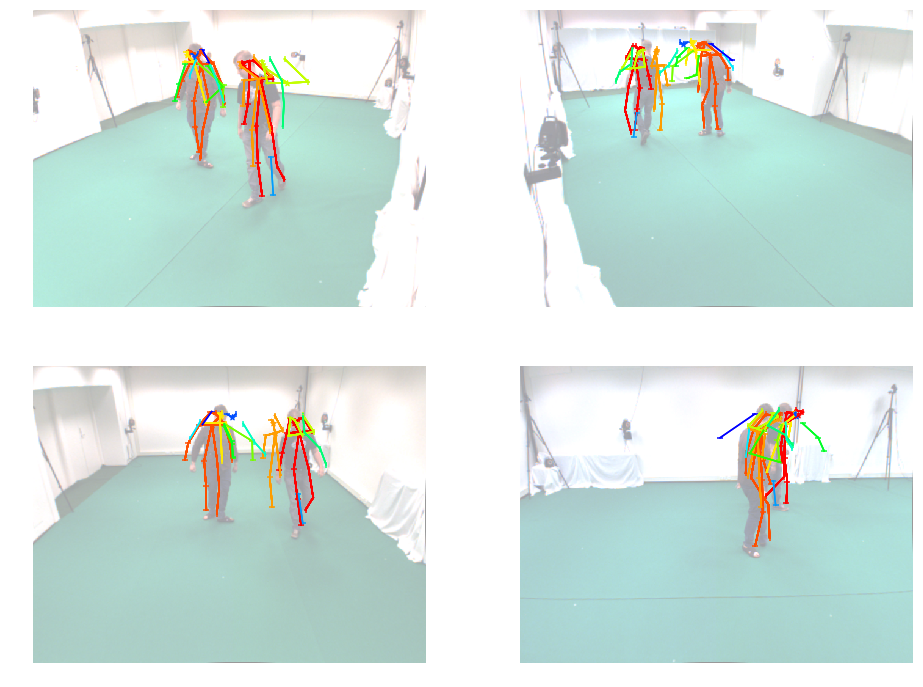

In [7]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

Humans = Debug.graphcut.person_candidates_all

fig = plt.figure(figsize=(16,12))

print()
colors = cs.rangecolor(len(Humans), (255, 0, 0), (0, 0, 255))/255

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    mapx = cam.mapx
    mapy = cam.mapy
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.show()